# Practice problems 2
## [Machine Learning](https://fagonzalezo.github.io/)

----
### **Auxilary functions**


In [1]:
import numpy as np
import pylab as pl

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    """
    X: corresponde a las instancias de nuestro conjunto de datos
    pred_fun: es una función que para cada valor de X, me regresa una predicción
    """
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 60)
    y_vals = np.linspace(min_y, max_y, 60)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            val = pred_fun(XX[i, j], YY[i, j])
            ZZ[i, j] = val[0] if isinstance(val, (np.ndarray, np.matrix)) else val
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -2, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### **Classification with linear functions**

Given the following dataset:

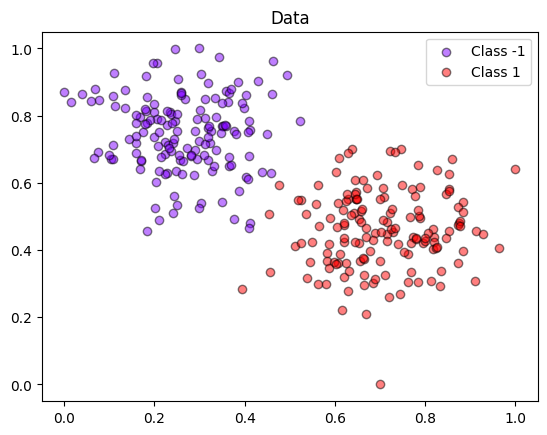

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import classification_report

X, y = make_blobs(n_samples=300, n_features=2, centers=2, random_state=115)
X = minmax_scale(X)
y = 2 * y - 1 #convert labels to -1, 1
plot_data(X, y)
pl.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We want to find a linear function $f(x) = wx+w_0$ with parameters $w \in \mathbb{R}^2$, $w_0 \in \mathbb{R}$. We formulate the problem as an optimization problem:

$$\min_{f\in H}L(f,D)$$

Where:
* $H$ is the hypothesis space defined as $H=\{f_{w, w_0}(x)=wx+w_0,\forall w\in\mathbb{R}^2 \ and \ w_0\in\mathbb{R}\}$.
* $L$ is the loss function defined as $ L(f, D) =\frac{1}{2}\sum_{(x^{(i)},y^{(i)})\in D} (f(x^{(i)}) - y^{(i)})^2 $.
* $(x^{(i)},y^{(i)})$ is a training sample where $y^{(i)}$ is the input and $y^{(i)}$ is the label.
* $D$ corresponds to the training dataset.

In [3]:
def f(w, x):
    """
     w: numpy array of shape (3,) w[1], w[2] coefficients of x, w[0] independent
        term
     x: numpy array of shape (2,)
    returns:
     a scalar y, with y<0 for class -1, y>=0 for class 1
    """
    a = np.dot(w[1:], x) + w[0]
    return a

In [4]:
def square_loss(w, x, y):
    '''
     Calculates the loss for a training sample.

     w: numpy array of shape (3,) w[1], w[2] coefficients of x, w[0] independent
        term
     x: numpy array of shape (2,)
     y: scalar
    '''
    return (y - f(w, x)) ** 2 / 2

def batch_loss(loss_fun, w, X, Y):
    '''
     Calculates the loss for a set of samples.

     loss_fun: a function that calculates the loss
     w: numpy array of shape (3,) w[1], w[2] coefficients of x, w[0] independent
        term
     X: numpy array of shape (n, 2) with n the number of samples.
     Y: numpy array of shape (n, ) with n the number of samples.
    '''
    assert(X.shape[0] == Y.shape[0])
    n = X.shape[0]
    tot_loss = 0
    for i in range(n):
        tot_loss += loss_fun(w, X[i], Y[i])
    return tot_loss

Input features: [0.41104796 0.48114158]
True label: -1
Predicted label: -0.09265059295538891
Training loss: 70.05432775986732
Test loss: 27.764063692100912


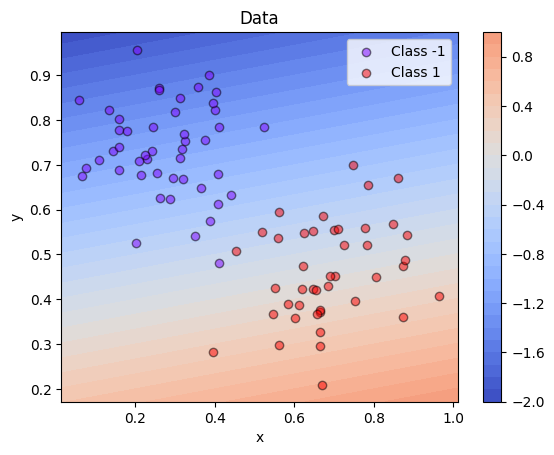

In [5]:
w = [1, .5, -3]
x = X_train[0]
label = y_train[0]

print('Input features: {}'.format(X[0]))
print('True label: {}'.format(y[0]))
print('Predicted label: {}'.format(f(w, x)))
print(f'Training loss: {batch_loss(square_loss, w, X_train, y_train)}')
print(f'Test loss: {batch_loss(square_loss, w, X_test, y_test)}')
plot_decision_region(X_test, lambda x_1, x_2: f(w, [x_1, x_2]))
plot_data(X_test, y_test)

We will use gradient descent to minimize the loss. To do so we need to calculate the gradient of the loss function with respect to the parameters.


$$
\begin{aligned} \frac{\partial L(f, D)}{\partial w} & =\frac{1}{2}\sum_{(x^{(i)},y^{(i)})\in D} \frac{\partial (f(x^{(i)}) - y^{(i)})^2}{\partial w}  
\end{aligned}
$$
with
$$
\begin{aligned}
\frac{\partial (f(x^{(i)}) - y^{(i)})^2}{\partial w} & =
\frac{\partial (w_1 x_1^{(i)} + w_2 x_2^{(i)} + w_0 - y^{(i)})^2}{\partial w} \\
& =(f_{w}(x^{(i)})-y^{(i)})\left[\begin{array}{c}
1 \\
x_1^{(i)}\\
x_2^{(i)}\\
\end{array}\right]
\end{aligned}
$$

Next, we define a function to calculate the gradient:

In [6]:
def dL_dw(w, x, y):
    '''
     Calculates the gradient of the loss function for one sample.
     w: numpy array of shape (3,) w[1], w[2] coefficients of x, w[0] independent
        term
     x: numpy array of shape (2,)
     y: scalar representing the label
    returns:
     a numpy array of shape (3,) with the gradients for each coefficient
    '''

    x_prime = np.zeros(len(x) + 1)
    x_prime[1:] = x
    x_prime[0] = 1
    return (f(w, x) - y) * x_prime

The following function implements gradient descent optimization

In [7]:
def batch_gd(X, Y, epochs, eta, w_ini):
    '''
    Gradient descent optimization
     X: numpy array of shape (n, 2) with n the number of samples.
     Y: numpy array of shape (n, ) with n the number of samples.
     epochs: number of iterations
     eta: learning rate
     w_ini: numpy array of shape (3,) with initial values for w
    Returns:
     w: final values of w
     lossess: list with loss values for each epoch
    '''
    losses = []
    w = w_ini
    n = X.shape[0] # número de ejemplos de entrenamiento
    for i in range(epochs):
        delta = np.zeros(len(w))
        for j in range(n):
            delta += dL_dw(w, X[j], Y[j]) # Vamos sumando el gradiente por cada ejemplo en el conjunto de datos
        w = w - eta * delta # Calculamos el nuevo valor de w
        losses.append(batch_loss(square_loss, w, X, Y)) # Vamos guardando el valor de pérdida para visualizar luego
    return w, losses

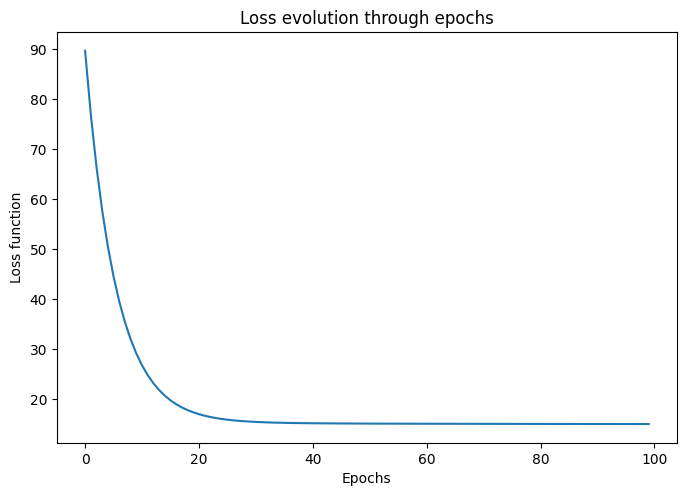

In [8]:
w, losses = batch_gd(X_train, y_train, 100, 0.005, np.array([0, 0, 0]))
pl.figure(figsize = (8,16/3))
pl.plot(losses)
pl.xlabel('Epochs')
pl.ylabel('Loss function')
pl.title('Loss evolution through epochs')
pl.show()

Input features: [0.41104796 0.48114158]
True label: -1
Predicted label: 0.8326839212776727
Training loss: 14.933392660672437
Test loss: 7.3826512551790895


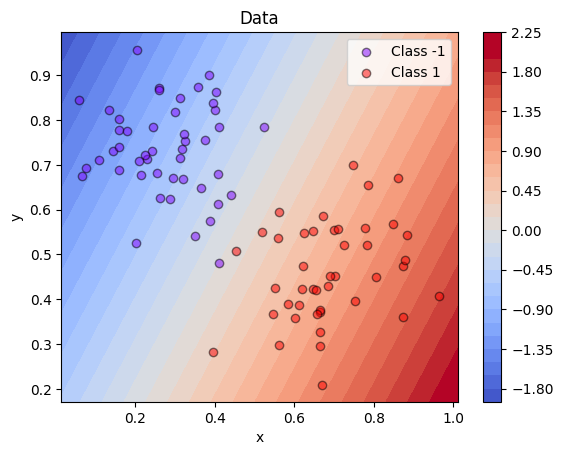

In [9]:
print('Input features: {}'.format(X[0]))
print('True label: {}'.format(y[0]))
print('Predicted label: {}'.format(f(w, x)))
print(f'Training loss: {batch_loss(square_loss, w, X_train, y_train)}')
print(f'Test loss: {batch_loss(square_loss, w, X_test, y_test)}')
plot_decision_region(X_test, lambda x_1, x_2: f(w, [x_1, x_2]))
plot_data(X_test, y_test)

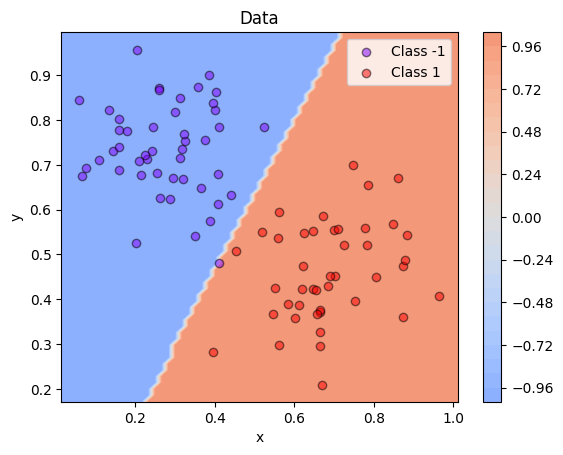

In [10]:
plot_decision_region(X_test, lambda x_1, x_2: np.sign(f(w, [x_1, x_2])))
plot_data(X_test, y_test)

In [11]:
y_pred = np.sign(f(w,X_test.T))
print(classification_report(y_true = y_test, y_pred = y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.98      0.99        47
           1       0.98      1.00      0.99        43

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



## 1. Train a prototype based model using gradient descent

Use gradient descent to train a classification model based on prototypes. Plot the decision region.

### Initial Version, euclidian distance based model (Single prototype per class)

For this initial version, we will define an amount of prototypes equal to the number of classes. Then, as a loss function for this problem, we can define it as the mean distance of each observation to its corresponding class prototype. 

As we can have $n$ classes related to $n$ prototypes, we can think this function as a vector of size $n$ where each component is related to the loss of the prototype. Then, we can define that each observation can be strcutured as a $n \times m$ (Where $m$ is the dimension of the data space) matrix where the value of the i-th row is the observation and it is alligned to the prototype row. Then we defined our loss function as:

$$f(p, x, y) = \|p_y - x\|$$


$$L(p, D) = \frac{1}{N} \sum_{(x^{(i)}, y^{(i)}) \in D} f(p, x^{(i)}, y^{(i)}) = \frac{1}{N} \sum_{(x^{(i)}, y^{(i)}) \in D} \|p_{y^{(i)}} - x^{(i)}\|$$

As we want to apply gradient descent to optimize the position of the prototypes, we will derivate $L(p,D)$ over the parameters $p$.

$$\frac{\partial f(p, x, y)}{\partial p_y} = \frac{p_y - x}{\|p_y - x\|}$$

$$\frac{\partial L(p, D)}{\partial p} = \frac{1}{N} \sum_{(x^{(i)}, y^{(i)}) \in D} \frac{p_{y^{(i)}} - x^{(i)}}{\|p_{y^{(i)}} - x^{(i)}\|}$$

This expression must carefully implemented in order to take into account the considerations done over the matricial operations


In [12]:
class NearestPrototypeClassifier:
  def __init__(self, num_classes, x_dim, random_state = 42):
    #In this schema, the i-th class is described by the i-th row which has the
    #prototype coordinates in space
    if random_state!=-1:
      np.random.seed(random_state)
      self.prototypes_ = np.random.rand(num_classes, x_dim)
    else:
      self.prototypes_ = np.zeros((num_classes, x_dim))
    self.index = None
    self.classes = None

  def fit(self, X, y, epochs = 100, lr = 0.001):
    # Use gradient descent to traing the model
    self.classes = np.unique(y)
    n , _ = X.shape
    self.index = {a:i for i,a in enumerate(self.classes)}
    proto_indices = np.array([self.index[label] for label in y])

    # Define an auxiliary function to calculate the gradient if necessary

    #Gradient function
    def dL_dp(X,y):
      dif = proto - X
      dif =  dif / np.linalg.norm(dif, axis = 1, keepdims=True) 
      return 1/n * np.sum(dif, axis=0)
    
    #Loss function
    def loss(X,y):
      distances = np.linalg.norm(proto - X, axis=1)
      return 1/n * np.sum(distances)
    
    #Gradient descent process
    losses = []
    for i in range(epochs):
      proto = self.prototypes_[proto_indices]
      delta = dL_dp(X,y)
      self.prototypes_ = self.prototypes_ - lr * delta
      losses.append(loss(X,y))

    return losses
  
  def getLoss(self,X,y):
    n , _ = X.shape
    proto = np.array([self.index[label] for label in y])
    proto = self.prototypes_[proto]
    distances = np.linalg.norm(proto - X, axis=1)
    return 1/n * np.sum(distances)
  
  def plotPrototypes2D(self):
    pl.scatter(self.prototypes_[:,0],
               self.prototypes_[:,1],
               color = 'green',
               label='Prototypes',
               marker = '*',
               s = 50)

  def predict(self, X):
    if type(X)==list: X = np.array(X)
    if X.ndim == 1: X = X.reshape(1, -1)
    distances = np.linalg.norm(self.prototypes_ - X[:, np.newaxis], axis=2)
    closest = np.argmin(distances, axis=1)
    return self.classes[closest]

### Upgraded version, euclidian distance based model (Multiple prototype per class)

For this initial version, we will define an amount of prototypes equal to the number of classes. Then, as a loss function for this problem, we can define it as the mean distance of each observation to its corresponding class prototype. 

As we can have $n$ classes related to $n$ prototypes, we can think this function as a vector of size $n \times k$ where each component is related to the loss of the prototypes. Then, we can define that each observation can be strcutured as a $n\times k \times m$ (Where $m$ is the dimension of the data space) matrix where the value of the i-th row is the observation and it is alligned to the prototype row. Then we defined our loss function as:

$$f(p, x, y) = \|p_y - x\|$$


$$L(p, D) = \frac{1}{N} \sum_{(x^{(i)}, y^{(i)}) \in D} f(p, x^{(i)}, y^{(i)}) = \frac{1}{N} \sum_{(x^{(i)}, y^{(i)}) \in D} \|p_{y^{(i)}} - x^{(i)}\|$$

As we want to apply gradient descent to optimize the position of the prototypes, we will derivate $L(p,D)$ over the parameters $p$.

$$\frac{\partial f(p, x, y)}{\partial p_y} = \frac{p_y - x}{\|p_y - x\|}$$

$$\frac{\partial L(p, D)}{\partial p} = \frac{1}{N} \sum_{(x^{(i)}, y^{(i)}) \in D} \frac{p_{y^{(i)}} - x^{(i)}}{\|p_{y^{(i)}} - x^{(i)}\|}$$

This expression must carefully implemented in order to take into account the considerations done over the matricial operations.


In [13]:
class NearestMultiplePrototypeClassifier:
    def __init__(self, num_classes, x_dim, num_proto=2, random_state=42):
        if random_state != -1:
            np.random.seed(random_state)
            self.prototypes_ = np.random.rand(num_classes, num_proto, x_dim)
        else:
            self.prototypes_ = np.zeros((num_classes, num_proto, x_dim))
        self.classes = None
        self.num_proto = num_proto
        self.base_index = None

    def fit(self, X, y, epochs=100, lr=0.001):
        # Use gradient descent to traing the model
        self.classes = np.unique(y)
        n, _ = X.shape
        self.base_index = {a:i for i,a in enumerate(self.classes)}
        proto_indices = np.array([self.base_index[label] for label in y])

        # Define an auxiliary function to calculate the gradient if necessary

        #Get closest valid prototype
        def getClosestProto(X, proto_indices):
            distances = np.linalg.norm(X[:, np.newaxis] - self.prototypes_[proto_indices], axis=2)
            closest_idx = np.argmin(distances, axis=1)
            return self.prototypes_[proto_indices, closest_idx, :]
        
        #Gradient
        def dL_dp(X, proto):
            dif = proto - X
            norms = np.linalg.norm(dif, axis=1, keepdims=True)
            safe_norms = np.where(norms == 0, 1e-10, norms)
            return dif / safe_norms

        #Loss function
        def loss(X):
            distances = np.linalg.norm(proto - X, axis=1)
            return np.mean(distances)
        
        #Gradient descent process
        losses = []
        for _ in range(epochs):
            proto = getClosestProto(X, proto_indices)
            gradient = dL_dp(X, proto)
            
            for i in range(len(self.classes)):

                #Update gradient on each specified prototype
                class_mask = (proto_indices == i)
                if np.any(class_mask):
                    closest_idx = np.argmin(
                        np.linalg.norm(X[class_mask][:, np.newaxis] - self.prototypes_[i], axis=2),
                        axis=1
                    )
                    unique_idx = np.unique(closest_idx)
                    for idx in unique_idx:
                        update_mask = (closest_idx == idx)
                        self.prototypes_[i, idx] -= lr * np.mean(gradient[class_mask][update_mask], axis=0)
            
            losses.append(loss(X))
        
        return losses

    def getLoss(self,X,y):
        proto_indices = np.array([self.base_index[label] for label in y])
        distances = np.linalg.norm(X[:, np.newaxis] - self.prototypes_[proto_indices], axis=2)
        closest_idx = np.argmin(distances, axis=1)
        proto =  self.prototypes_[proto_indices, closest_idx, :]
        distances = np.linalg.norm(proto - X, axis=1)
        return np.mean(distances)

    def plotPrototypes2D(self):
        colors = [
            '#2ca02c',  # Green
            '#17becf',  # Teal
            '#9467bd',  # Purple
            '#8c564b',  # Brown
            '#7f7f7f',  # Gray
            '#bcbd22',  # Olive   
        ]
        for i, c in enumerate(self.classes):
            pl.scatter(self.prototypes_[i,:,0],
                    self.prototypes_[i,:,1],
                    label=f'Prototypes class {c}',
                    marker = '*',
                    color = colors[i%len(colors)],
                    s = 50)

    def predict(self, X):
        if isinstance(X, list):
            X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        distances = np.zeros((X.shape[0], len(self.classes)))
        for i, class_prototypes in enumerate(self.prototypes_):
            distances[:, i] = np.min(np.linalg.norm(X[:, np.newaxis] - class_prototypes, axis=2), axis=1)
        
        return self.classes[np.argmin(distances, axis=1)]

## 2. Dealing with non-linearly-separable classes

Apply the previous model to the following dataset:

* What's the problem?
* How to deal with it?
* Propose a solution.

### First non-linear exmaple (4 centers)

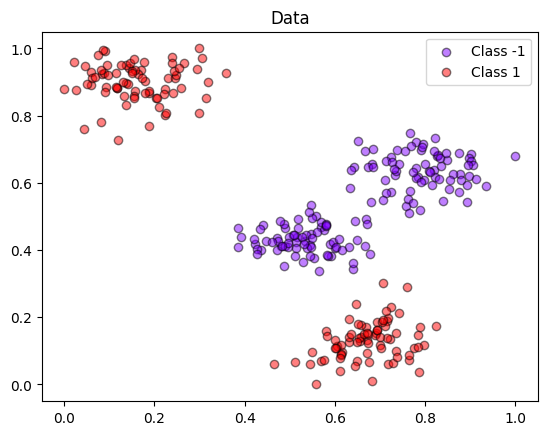

In [14]:
X, y = make_blobs(n_samples=300, n_features=2, centers=4, random_state=109)
X = minmax_scale(X)
y = 2 * (y % 2) - 1 #convert labels to -1, 1
plot_data(X, y)
pl.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Initial Version, euclidian distance based model (Single prototype per class)

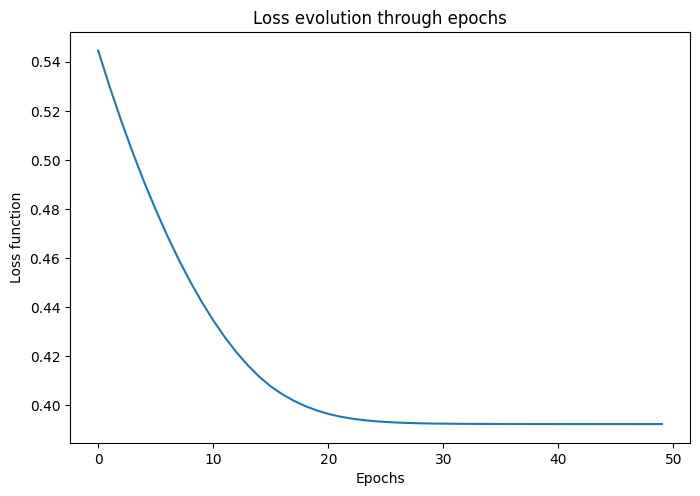

In [15]:
num_classes = len(np.unique(y))
_ , x_dim = X.shape
model = NearestPrototypeClassifier(num_classes, x_dim, random_state=42)
losses = model.fit(X_train,y_train,lr = 0.05,epochs=50)
pl.figure(figsize = (8,16/3))
pl.plot(losses)
pl.xlabel('Epochs')
pl.ylabel('Loss function')
pl.title('Loss evolution through epochs')
pl.show()

Input features: [[0.21049549 0.8260643 ]]
True label: [1]
Predicted label: [-1]
Training loss: 0.39243533183485046
Test loss: 0.4511904792472195


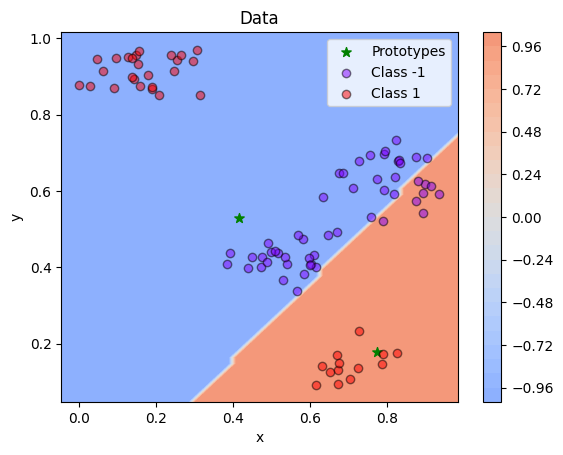

In [16]:
X_s , y_s = X_train[:1] , y_train[:1]
print('Input features: {}'.format(X_s))
print('True label: {}'.format(y_s))
print('Predicted label: {}'.format(model.predict(X_s)))
print(f'Training loss: {model.getLoss(X_train,y_train)}')
print(f'Test loss: {model.getLoss(X_test,y_test)}')
plot_decision_region(X_test, lambda x_1, x_2: model.predict([x_1, x_2]))
model.plotPrototypes2D()
plot_data(X_test, y_test)


In [17]:
y_pred = model.predict(X_test)
print(classification_report(y_true = y_test, y_pred = y_pred))

              precision    recall  f1-score   support

          -1       0.64      0.85      0.73        52
           1       0.62      0.34      0.44        38

    accuracy                           0.63        90
   macro avg       0.63      0.59      0.58        90
weighted avg       0.63      0.63      0.61        90



#### Upgraded version, euclidian distance based model (Multiple prototype per class)

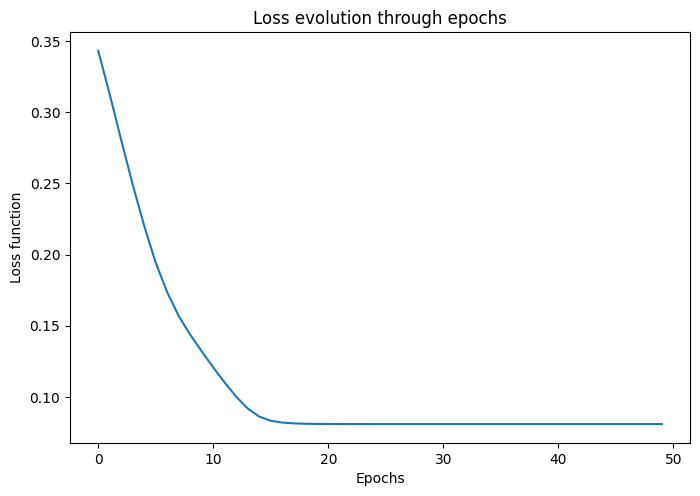

In [18]:
num_classes = len(np.unique(y))
_ , x_dim = X.shape
model = NearestMultiplePrototypeClassifier(num_classes, x_dim, num_proto=2, random_state=25)
losses = model.fit(X_train,y_train,lr = 0.05,epochs=50)
pl.figure(figsize = (8,16/3))
pl.plot(losses)
pl.xlabel('Epochs')
pl.ylabel('Loss function')
pl.title('Loss evolution through epochs')
pl.show()

Input features: [[0.21049549 0.8260643 ]]
True label: [1]
Predicted label: [1]
Training loss: 0.08093317893663336
Test loss: 0.08028916290784315


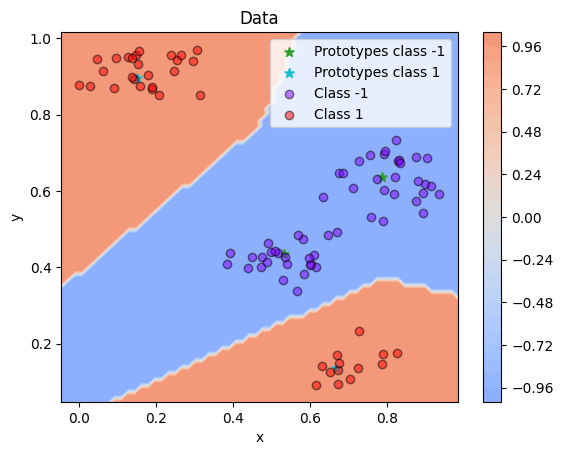

In [19]:
X_s , y_s = X_train[:1] , y_train[:1]
print('Input features: {}'.format(X_s))
print('True label: {}'.format(y_s))
print('Predicted label: {}'.format(model.predict(X_s)))
print(f'Training loss: {model.getLoss(X_train,y_train)}')
print(f'Test loss: {model.getLoss(X_test,y_test)}')
plot_decision_region(X_test, lambda x_1, x_2: model.predict([x_1, x_2]))
model.plotPrototypes2D()
plot_data(X_test, y_test)

In [20]:
y_pred = model.predict(X_test)
print(classification_report(y_true = y_test, y_pred = y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        38

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



### Second non-linear exmaple (circles)

Apply the new model to this dataset. Does it work?

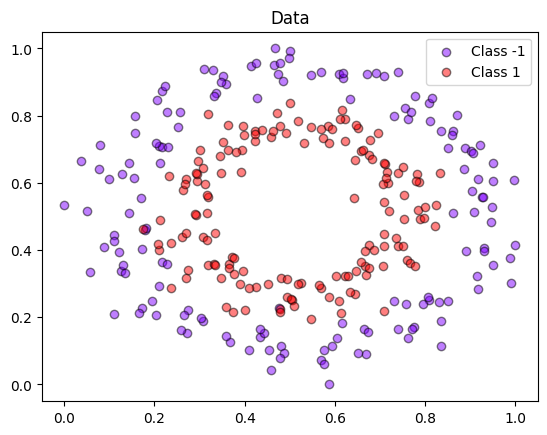

In [21]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=300, noise=0.1, factor=0.6, random_state=109)
X = minmax_scale(X)
y = 2 * (y % 2) - 1 #convert labels to -1, 1
plot_data(X, y)
pl.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Initial Version, euclidian distance based model (Single prototype per class)

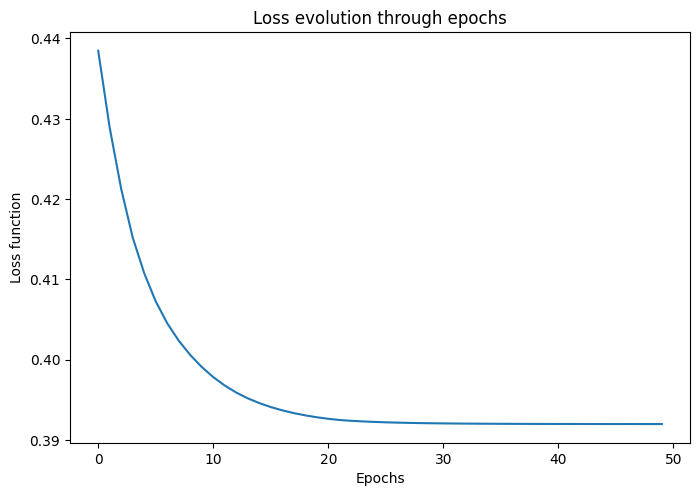

In [22]:
num_classes = len(np.unique(y))
_ , x_dim = X.shape
model = NearestPrototypeClassifier(num_classes, x_dim, random_state=42)
losses = model.fit(X_train,y_train,lr = 0.05, epochs=50)
pl.figure(figsize = (8,16/3))
pl.plot(losses)
pl.xlabel('Epochs')
pl.ylabel('Loss function')
pl.title('Loss evolution through epochs')
pl.show()

Input features: [[0.26841697 0.59676595]]
True label: [1]
Predicted label: [-1]
Training loss: 0.3919714807241078
Test loss: 0.36801859035848616


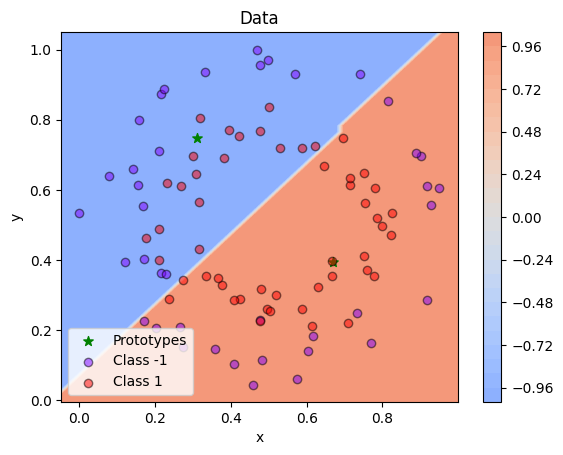

In [23]:
X_s , y_s = X_train[:1] , y_train[:1]
print('Input features: {}'.format(X_s))
print('True label: {}'.format(y_s))
print('Predicted label: {}'.format(model.predict(X_s)))
print(f'Training loss: {model.getLoss(X_train,y_train)}')
print(f'Test loss: {model.getLoss(X_test,y_test)}')
plot_decision_region(X_test, lambda x_1, x_2: model.predict([x_1, x_2]))
model.plotPrototypes2D()
plot_data(X_test, y_test)

In [24]:
y_pred = model.predict(X_test)
print(classification_report(y_true = y_test, y_pred = y_pred))

              precision    recall  f1-score   support

          -1       0.51      0.47      0.49        40
           1       0.60      0.64      0.62        50

    accuracy                           0.57        90
   macro avg       0.56      0.56      0.56        90
weighted avg       0.56      0.57      0.56        90



#### Upgraded version, euclidian distance based model (Multiple prototype per class)

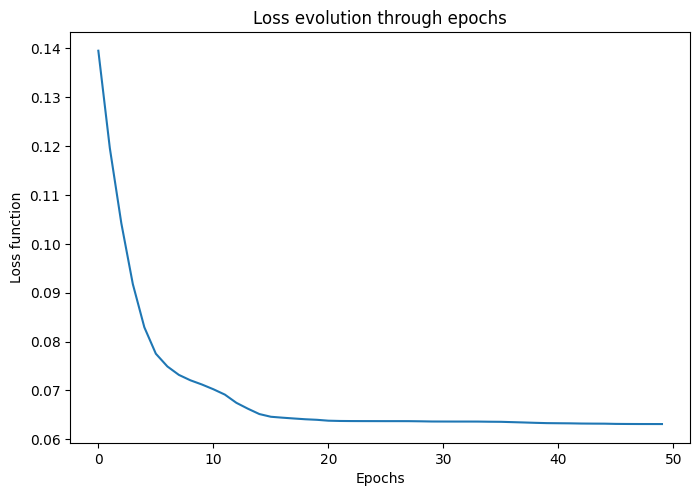

In [25]:
num_classes = len(np.unique(y))
_ , x_dim = X.shape
model = NearestMultiplePrototypeClassifier(num_classes, x_dim, num_proto=12, random_state=25)
losses = model.fit(X_train,y_train,lr = 0.05,epochs=50)
pl.figure(figsize = (8,16/3))
pl.plot(losses)
pl.xlabel('Epochs')
pl.ylabel('Loss function')
pl.title('Loss evolution through epochs')
pl.show()

Input features: [[0.26841697 0.59676595]]
True label: [1]
Predicted label: [1]
Training loss: 0.063099056652369
Test loss: 0.0806051531759025


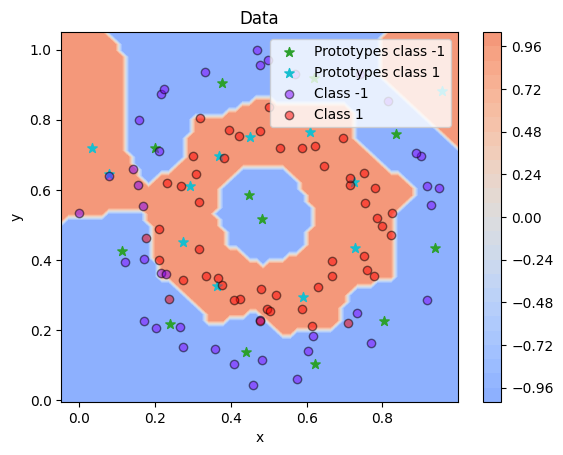

In [26]:
X_s , y_s = X_train[:1] , y_train[:1]
print('Input features: {}'.format(X_s))
print('True label: {}'.format(y_s))
print('Predicted label: {}'.format(model.predict(X_s)))
print(f'Training loss: {model.getLoss(X_train,y_train)}')
print(f'Test loss: {model.getLoss(X_test,y_test)}')
plot_decision_region(X_test, lambda x_1, x_2: model.predict([x_1, x_2]))
model.plotPrototypes2D()
plot_data(X_test, y_test)

In [27]:
y_pred = model.predict(X_test)
print(classification_report(y_true = y_test, y_pred = y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.82      0.85        40
           1       0.87      0.90      0.88        50

    accuracy                           0.87        90
   macro avg       0.87      0.86      0.86        90
weighted avg       0.87      0.87      0.87        90



## 3. (optional) Training a Gaussian classifier with gradient descent

How would you train the Gaussian classifier with gradient descent?

As the Gaussian Classifier aims to estimate the parameters of the Gaussian probability distributions that model each class, we define a classifier that learns the **mean vectors** $ \mu_j $, the **diagonal covariance matrices** $ \Sigma_j $, and the **prior probabilities** $ \pi_j $ for each of the $ k $ classes. To ensure that the priors are valid probabilities (i.e., non-negative and summing to one), we parameterize them using a softmax over a set of learnable logits $ \alpha_j $, such that:

$$
\pi_j = \frac{e^{\alpha_j}}{\sum_{l=1}^{k} e^{\alpha_l}}
$$

To train the model, we use a loss function suitable for probabilistic modeling: the **negative log-likelihood (NLL)**. This function measures how well the estimated distributions explain the observed data. The loss is defined as:

$$
\text{NLL}(D, P) = - \sum_{(x^{(i)}, y^{(i)}) \in D} \log \left( \sum_{j=1}^{k} \pi_j \cdot \mathcal{N}(x^{(i)} \mid \mu_j, \Sigma_j) \right)
$$

This expression captures the **marginal probability** of observing each data point $ x^{(i)} $, accounting for all possible class assignments, weighted by the priors. Unlike simplified alternatives, this form ensures that the optimization process adjusts the model by considering all classes and their overlap.

Using the standard form of the **logarithm of a multivariate Gaussian with diagonal covariance**, we can expand the inner term as:

$$
\log \mathcal{N}(x \mid \mu_j, \Sigma_j) = - \frac{k}{2} \log(2\pi) - \frac{1}{2} \log |\Sigma_j| - \frac{1}{2} (x - \mu_j)^T \Sigma_j^{-1} (x - \mu_j)
$$

So, plugging this back into the NLL yields a tractable form that is numerically stable and suitable for gradient-based optimization.

We now derive the gradients of this loss with respect to the model parameters, using **soft responsibilities** $ r_{ij} $ defined as:

$$
r_{ij} = \frac{\pi_j \cdot \mathcal{N}(x^{(i)} \mid \mu_j, \Sigma_j)}{\sum_{l=1}^{k} \pi_l \cdot \mathcal{N}(x^{(i)} \mid \mu_l, \Sigma_l)}
$$

These responsibilities reflect the posterior probability that sample $ x^{(i)} $ belongs to class $ j $ under the current model.

The gradients are then given by:

---

### Gradient with respect to the means $ \mu_j $:

$$
\frac{\partial \mathcal{L}}{\partial \mu_j} = \frac{1}{N} \sum_{i=1}^N r_{ij} \cdot \Sigma_j^{-1} ( \mu_j - x^{(i)} )
$$

---

### Gradient with respect to the log-variances (diagonal covariance) $ \log \sigma_j^2 $:

$$
\frac{\partial \mathcal{L}}{\partial \log \sigma_j^2} = \frac{1}{2N} \sum_{i=1}^N r_{ij} \cdot \left( \frac{(x^{(i)} - \mu_j)^2}{\sigma_j^2} - 1 \right)
$$

where all operations are element-wise, and $ \sigma_j^2 = \text{diag}(\Sigma_j) $.

---

### Gradient with respect to the prior logits $ \alpha_j $:

$$
\frac{\partial \mathcal{L}}{\partial \alpha_j} = \frac{1}{N} \sum_{i=1}^N \left( r_{ij} - \pi_j \right)
$$

This is analogous to the gradient of the cross-entropy loss, comparing the posterior assignments $ r_{ij} $ with the current prior $ \pi_j $ obtained from softmax.

---

### Additional considerations:

1. The priors $ \pi_j $ are computed via softmax from $ \alpha_j $, so they are always normalized:  
   $$
   \sum_{j=1}^{k} \pi_j = 1
   $$

2. The diagonal covariance matrices $ \Sigma_j $ must remain **positive definite**. We ensure this by parameterizing them via their **log-variances**, i.e., optimizing $ \log \sigma^2_j $, which guarantees positivity after exponentiation.

3. Appropriate initialization of parameters (e.g., sampling means from the data, initializing log-variances near zero, and priors near uniform) helps in ensuring convergence and numerical stability.

With this setup, we can train the Gaussian classifier using any gradient-based optimizer by updating $ \mu_j $, $ \log \sigma_j^2 $, and $ \alpha_j $ using the gradients above.


### Model from sklearn

In [28]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)

QuadraticDiscriminantAnalysis()

Input features: [[0.26841697 0.59676595]]
True label: [1]
Predicted label: [1]


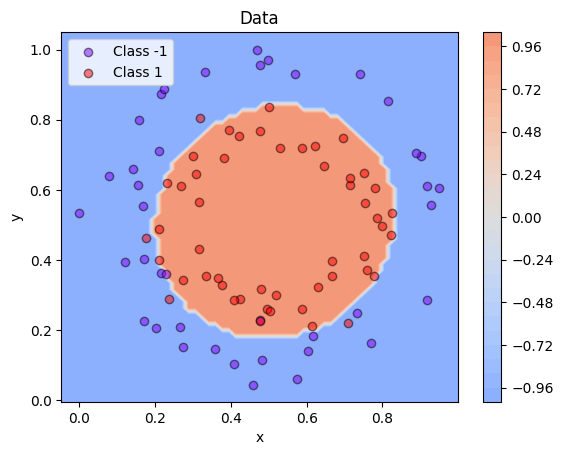

In [29]:
X_s , y_s = X_train[:1] , y_train[:1]
print('Input features: {}'.format(X_s))
print('True label: {}'.format(y_s))
print('Predicted label: {}'.format(model.predict(X_s)))
plot_decision_region(X_test, lambda x_1, x_2: qda.predict(np.array([x_1, x_2]).reshape(1,-1)))
plot_data(X_test, y_test)

In [30]:
y_pred = qda.predict(X_test)
print(classification_report(y_true = y_test, y_pred = y_pred))

              precision    recall  f1-score   support

          -1       0.88      0.95      0.92        40
           1       0.96      0.90      0.93        50

    accuracy                           0.92        90
   macro avg       0.92      0.93      0.92        90
weighted avg       0.92      0.92      0.92        90



### Model trained with gradient descent